In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import cPickle as pickle
from multiprocessing import Pool

import geopy
import geopandas as gpd
import shapely.geometry as geom

In [2]:
pd.options.display.max_columns = 60

In [3]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.shape

(3178229, 58)

### Ride Distances

In my first notebook I examined the differences between male and female riders. It seemed that on average, women were on the bike longer. Let's explore whether that is due to further rides or slower rides.

In [5]:
# convert start and stop locs to geo points
data['start_long_lat']= data['long_lat']
data['start_lat_long']= data['lat_long']
data['end_long_lat'] = zip(data['end station longitude'].values, data['end station latitude'])
data['end_lat_long'] = zip(data['end station latitude'].values, data['end station longitude'])
data['start_geoPoint'] = data['geo_points']
data['end_geoPoint'] = data.end_long_lat.map(geom.Point)

data.drop(['long_lat','lat_long','geo_points'], axis = 1, inplace = True)

In [13]:
dists = []

Using shapely, we can calculate the approximate distance between stations in degrees and then convert to miles.

I say approximately because this is assuming manhattan is on a flat plane and does not account for the curvature of the earth.

However, since the area we are looking at is so small, I beleive the approximation will be good enough for our purposes.

In [33]:
def get_dist(i):
    return data.ix[i,'start_geoPoint'].distance(data.ix[i,'end_geoPoint'])
# Takes at least half hour
pool = Pool(4)
dists.extend(pool.map(get_dist, data.index[3000000:]))
pool.close()

In [34]:
print len(dists)
with open('station_dists.pkl','wb') as f:
    pickle.dump(dists, f, 2)

3178229


In [64]:
# convert degrees into approximate miles
data['ride_dist'] = dists
data['ride_dist'] = data.ride_dist.map(lambda x: radians(x)*3956)

Mean Ride Distance: 1.19 miles


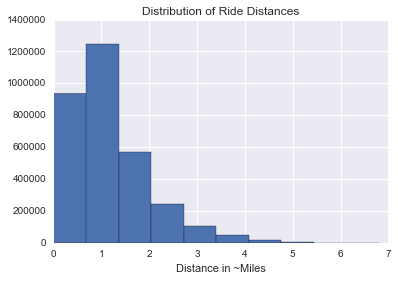

In [72]:
print "Mean Ride Distance:", data.ride_dist.mean().round(2), "miles"
data.ride_dist.hist()
plt.title('Distribution of Ride Distances')
plt.xlabel('Distance in ~Miles')

#### Ride Distances for Men vs Women

The distributions of ride distances are about the same between the sexes, which would indicate that women tend to bike slower than men.

We can confirm this by calculating the average speed of each ride

Mean Ride Distance for Men: 1.17
Mean Ride Distance for Women: 1.22


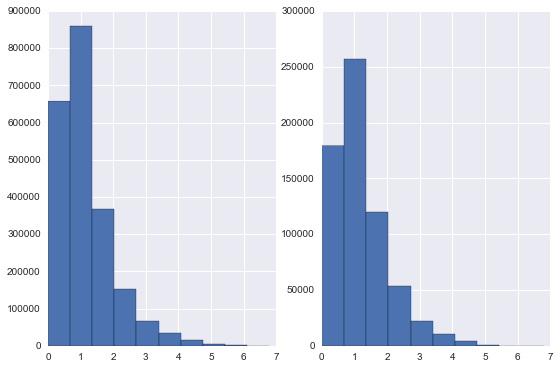

In [73]:
fig, axes = plt.subplots(1,2, figsize = (9,6))

print "Mean Ride Distance for Men:", data[data.gender==1].ride_dist.mean().round(2)
print "Mean Ride Distance for Women:", data[data.gender==2].ride_dist.mean().round(2)

data[data.gender==1].ride_dist.hist(ax = axes[0])
data[data.gender==2].ride_dist.hist(ax = axes[1])

In [ ]:
data

In [ ]:
data['average_speed']= data.ride_dist/data.

In [4]:
gdata = data[['starttime','stoptime','start station id', 'start station name','start station latitude', 'start station longitude','end station id', 'end station name', 'end station latitude', 'end station longitude', 
                               'bikeid', 'usertype', 'birth year', 'gender','zipcode', 'geo_points','zoning_idx', 'zonedist', 'zone_type', 'CD', 
                               '2000 Population', '2010 Population', 'station_mean_usg']]

zoning_data = gpd.read_file('Zoning GIS Data- Shapefile.geojson')
zoning_data.shape

(15714, 20)

In [77]:
nycd = gpd.read_file('nycd.json')
nycd.drop(nycd[nycd.borough=='Staten Island'].index, inplace=True)
print nycd.shape

gdata = zoning_data[['geometry', 'shape_area','shape_leng']].merge(gdata, right_on = 'zoning_idx', left_index = True)
gdata.shape

(256, 5)


(3178229, 38)

In [78]:
scaled_strt= (gdata.groupby('start station id').size()-gdata.groupby('start station id').size().min())/(gdata.groupby('start station id').size().max()-gdata.groupby('start station id').size().min())
scaled_end = (gdata.groupby('end station id').size()-gdata.groupby('end station id').size().min())/(gdata.groupby('end station id').size().max()-gdata.groupby('end station id').size().min())

Here are all the stations in the city, sized by total usage:

We see heavy usage in midtown west, dumbo, and east village, as well as high usage throughout brooklyn

(40.65, 40.85)

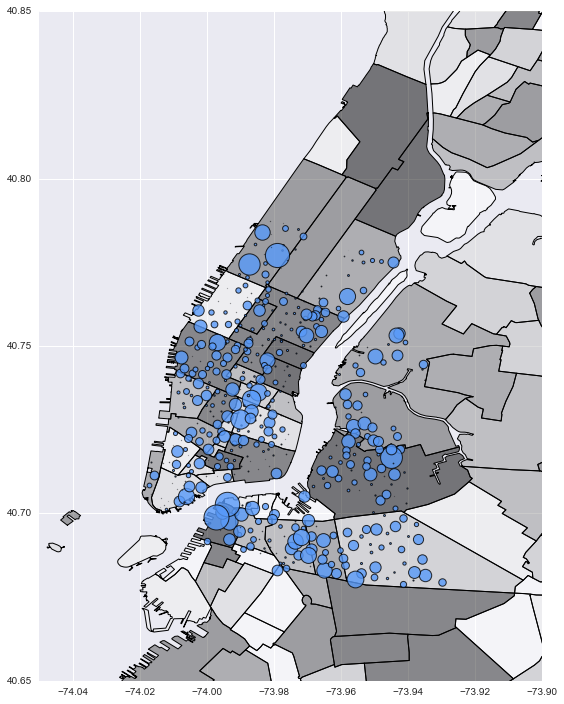

In [94]:
# xlim(-74.05, -73.9)
# ylim(40.65, 40.85)


base = nycd.plot(figsize = (16,12))
for i,v in enumerate(gdata.drop_duplicates('start station id').geo_points.values):
    gpd.plotting.plot_point(base,v, 
                        color =(0.34509803921568629, 0.60392156862745098, 0.98039215686274515, 0.8) ,
                        markersize = scaled_strt.iloc[i]*25,
                        markeredgewidth=1)
plt.xlim(-74.05, -73.9)
plt.ylim(40.65, 40.85)

    - Do women ride slower or further?
        o ride dist vs ride time
    - Plot ride density on map
    - plot ride density by male/female
    - plot ride density by age

### Explore Weather

(3178229, 58)

In [41]:
Y = data.groupby(['date','start station id']).size()
print Y.shape

X = data.sort_values(['date','start station id']).drop_duplicates(['date','start station id'])
print X.shape



# season, day of the week, zone type, borough, and CD are categorical and need to be 1-hot encoded
season_col = pd.get_dummies(X.season)
dow_col = pd.get_dummies(X.dow)
zonetype_col = pd.get_dummies(X.zone_type)
borough_col = pd.get_dummies(X.Borough)

print season_col.shape
print dow_col.shape
print zonetype_col.shape
print borough_col.shape

(43541,)
(43541, 58)
(43541, 4)
(43541, 7)
(43541, 5)
(43541, 3)


In [42]:
ftr_cols = ['dew_point', u'max_temp', u'mean_temp', u'min_temp', u'precip',
       u'month_precip', u'snow', u'month_snow', u'wind_speed',
       u'PERCENT FEMALE', u'PERCENT MALE', u'PERCENT PACIFIC ISLANDER',
       u'PERCENT HISPANIC LATINO', u'PERCENT AMERICAN INDIAN',
       u'PERCENT ASIAN NON HISPANIC', u'PERCENT WHITE NON HISPANIC',
       u'PERCENT BLACK NON HISPANIC', u'PERCENT OTHER ETHNICITY', 
      '2000 Population', '2010 Population', 'station_mean_usg','busy_stn']
x = pd.merge(X[ftr_cols], season_col, 
             left_index=True, right_index = True).merge(dow_col, 
                                left_index=True, right_index = True).merge(zonetype_col, 
                                    left_index=True, right_index = True).merge(borough_col, left_index = True,
                                                    right_index=True).reset_index()
y = Y.reset_index(drop=True)
print x.shape, y.shape
x.head()

(43541, 42) (43541,)


,index,dew_point,max_temp,mean_temp,min_temp,precip,month_precip,snow,month_snow,wind_speed,PERCENT FEMALE,PERCENT MALE,PERCENT PACIFIC ISLANDER,PERCENT HISPANIC LATINO,PERCENT AMERICAN INDIAN,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT OTHER ETHNICITY,2000 Population,2010 Population,station_mean_usg,busy_stn,fall,spring,summer,winter,friday,monday,saturday,sunday,thursday,tuesday,wednesday,B,C,M,PARK,R,Brooklyn,Manhattan,Queens
0,1484821,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.396574,0.245738,0.0,0.087661,0.0,0.340823,0.040262,0.128996,0.041221,87479,103245,74.073171,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1488279,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.130000,0.880000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,34420,60978,61.090164,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1487118,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.690000,0.310000,0.0,0.130000,0.0,0.560000,0.000000,0.310000,0.000000,164407,163277,26.577236,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1485960,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.396574,0.245738,0.0,0.087661,0.0,0.340823,0.040262,0.128996,0.041221,98620,99617,29.577236,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1484646,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.670000,0.330000,0.0,0.330000,0.0,0.000000,0.000000,0.330000,0.330000,87479,103245,136.545455,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
x['Pop_Growth'] = (x['2010 Population'] - x['2000 Population'])/x['2000 Population']
# The data is too sparse and not useful
x= x.drop(['PERCENT PACIFIC ISLANDER', 'PERCENT AMERICAN INDIAN'], axis = 1)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x.ix[:,1:],y)

In [46]:
lreg = LinearRegression(n_jobs = -1, normalize=True)
l1 = Lasso(alpha = 0.0005, normalize=True)
lreg.fit(x_train, np.log(y_train))
l1.fit(x_train, np.log(y_train))

preds = lreg.predict(x_test)
print "LREG:", np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))

preds2 = l1.predict(x_test)
print "L1:", np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

LREG: 0.518129089185
L1: 0.590128663619


In [47]:
rfor = RandomForestRegressor(n_estimators=100, max_features = 'sqrt', max_depth = 10)
rfor.fit(x_train,np.log(y_train))
etree = ExtraTreesRegressor(n_estimators=150, max_depth=10, bootstrap=True)
etree.fit(x_train, np.log(y_train))

preds = rfor.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))

preds2 = etree.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

print np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds2)))

0.42447469927
0.391453739697
25.5049797473


In [48]:
import xgboost

xg = xgboost.XGBRegressor(objective='count:poisson',learning_rate=0.08, max_depth = 15)
xg.fit(x_train, np.log(y_train))

preds = xg.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))
np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds)))

0.344185294072


18.841771825743006

In [49]:
# Some Feature Selection
sorted(zip(x_test.columns, lreg.coef_), key = lambda x: abs(x[1]), reverse = True)[:25]
sorted(zip(x_test.columns, etree.feature_importances_), key = lambda x: abs(x[1]), reverse = True)[:25]


[('Manhattan', 0.32532436978933105),
 ('station_mean_usg', 0.26736578434473784),
 ('winter', 0.25386509340435093),
 (u'precip', 0.029709263068972688),
 ('spring', 0.017274318461378745),
 (u'snow', 0.012148707022101456),
 (u'wind_speed', 0.011352679538354988),
 ('saturday', 0.010883299876466627),
 (u'mean_temp', 0.0074335985812676343),
 (u'month_precip', 0.0067335548002365611),
 (u'max_temp', 0.0065547160380561211),
 ('sunday', 0.0058898299915986288),
 (u'min_temp', 0.0044370298198278587),
 (u'dew_point', 0.0039396197906818803),
 (u'month_snow', 0.0038712837511694852),
 ('tuesday', 0.0037808777860581441),
 ('Pop_Growth', 0.0033536205781845062),
 ('2000 Population', 0.0033522280509996408),
 ('2010 Population', 0.0033184240653628774),
 ('busy_stn', 0.003193216563880226),
 (u'M', 0.0016320109103607624),
 ('PERCENT HISPANIC LATINO', 0.0013638856586555299),
 (u'R', 0.0011741024489376533),
 (u'C', 0.0011348352852996939),
 ('friday', 0.0010824114478668392)]

In [52]:
x_train.shape


(32655, 40)

In [53]:
# Chosen by examining the top feature importances + trial and error
# Reduce the dimensinoalilty by ~ 1/3
x = x.drop(x.columns[~x.columns.isin(['winter', 'Manhattan', u'precip', 'Pop_Growth', u'2010 Population', u'2000 Population', 'saturday', 
u'snow', u'C', 'Brooklyn', 'sunday', u'month_precip', u'PERCENT HISPANIC LATINO', u'PERCENT FEMALE', 
u'PERCENT MALE', u'R', u'month_snow', u'M', 'PERCENT ASIAN NON HISPANIC', 'tuesday', u'PARK', 
u'PERCENT WHITE NON HISPANIC', u'PERCENT OTHER ETHNICITY', u'dew_point', 'PERCENT BLACK NON HISPANIC', 'station_mean_usg','busy_stn'])], axis =1)


In [54]:
# same performance, less features
x_train, x_test, y_train, y_test = train_test_split(x,y)

etree = ExtraTreesRegressor(n_estimators=100, max_depth=10, bootstrap=False)
etree.fit(x_train, np.log(y_train))

preds2 = etree.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

print np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds2)))

0.398534831518
26.9546585906


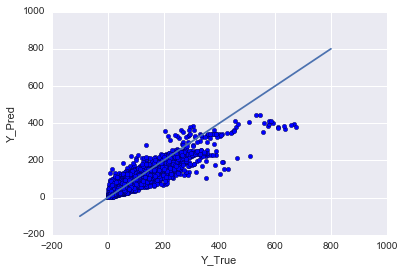

In [55]:
# Tendency to Under-Predict
plt.scatter(y_test, np.exp(preds2))
plt.xlabel('Y_True')
plt.ylabel('Y_Pred')
plt.plot(plt.xlim(), plt.xlim())